In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
import math

In [2]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

In [4]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


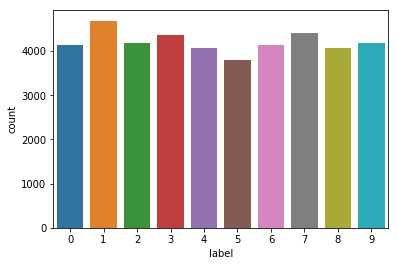

In [12]:
g = sns.countplot(Y_train)

In [5]:
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [6]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes = 10)

In [9]:
Y_train.shape

(42000, 10)

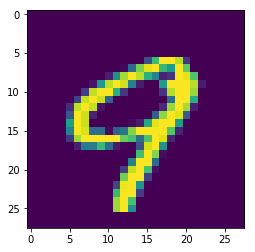

In [11]:
g = plt.imshow(X_train[100][:,:,0])

In [10]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [11]:
type(X_train)

numpy.ndarray

In [15]:
def forward_propagation(X):
    """
    Implements the forward propagation for the model:
    (CONV2D -> RELU)*2 -> MAXPOOL -> Dropout -> (CONV2D -> RELU)*2 -> MAXPOOL -> Dropout -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Weights initialization 
    W1 = tf.get_variable("W1", [5, 5, 1, 4], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b1 = tf.get_variable("b1", shape=[4], initializer=tf.constant_initializer(0.0))

    W2 = tf.get_variable("W2", [5, 5, 4, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b2 = tf.get_variable("b2", shape=[8], initializer=tf.constant_initializer(0.0))

    W3 = tf.get_variable("W3", [4, 4, 8, 12], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    b3 = tf.get_variable("b3", shape=[12], initializer=tf.constant_initializer(0.0))

    
    # CONV2D: stride of 1, padding 'SAME'
    A1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME') + b1
    # RELU
    Z1 = tf.nn.relu(A1)
    
    # CONV2D: stride of 1, padding 'SAME'
    A2 = tf.nn.conv2d(Z1, W2, strides=[1, 2, 2, 1], padding='SAME') + b2
    # RELU
    Z2 = tf.nn.relu(A2)

    # CONV2D: stride of 1, padding 'SAME'
    A3 = tf.nn.conv2d(Z2, W3, strides=[1, 2, 2, 1], padding='SAME') + b3
    # RELU
    Z3 = tf.nn.relu(A3)
    
    
    # FLATTEN
    P = tf.contrib.layers.flatten(Z3)

    # FULLY-CONNECTED with relu activation function.
    # 200 neurons in output layer.
    Z4 = tf.contrib.layers.fully_connected(P, 200)
    
    # FULLY-CONNECTED without non-linear activation function.
    # 10 neurons in output layer.  
    Z5 = tf.contrib.layers.fully_connected(Z4, 10, activation_fn=None)
   


    print(X.shape)
    print(Z1.shape)
    print(Z2.shape)
    print(Z3.shape)
    print(Z4.shape)
    print(Z5.shape)

    return Z5

In [13]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [16]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None, 10])

Z5 = forward_propagation(X)

(?, 28, 28, 1)
(?, 28, 28, 4)
(?, 14, 14, 8)
(?, 7, 7, 12)
(?, 200)
(?, 10)


In [17]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z5, labels=Y))

optimizer = tf.train.AdamOptimizer(learning_rate=.001).minimize(cost)

init = tf.global_variables_initializer()

In [18]:
minibatch_size = 32
num_epochs = 5
m = len(X_train)
tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
seed = 3                                          # to keep results consistent (numpy seed) 
print_cost = True
costs = []

with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            #seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        '''
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        '''

        # Calculate the correct predictions
        predict_op = tf.argmax(Z5, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        dev_accuracy = accuracy.eval({X: X_val, Y: Y_val})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)

Cost after epoch 0: 0.224280
Cost after epoch 1: 0.077376
Cost after epoch 2: 0.052274
Cost after epoch 3: 0.037876
Cost after epoch 4: 0.026590
Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9920899
Dev Accuracy: 0.97809523
